In [1]:
from tools import *
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
def logpdfTarget (x, mu, covariance_inverse):
    lnp = -(1/2) * ((x-mu).T).dot(covariance_inverse).dot(x-mu)
    return(lnp)

In [3]:
# Estimated covariance and Mean would be intialized as Identiy Matrix and Zero Vector.
np.random.seed(12)
d = 1000
mu_y = true_mu = np.zeros(d)
sigma_inverse_y = true_sigma_inverse = wishart.rvs(df=d,scale=np.eye(d))
true_sigma = np.linalg.inv(true_sigma_inverse)
mu_hat = np.zeros(d); Sigma_neg = Sigma_pos = sigma_hat = np.eye(d)
print(np.sum(abs(true_sigma)>0.99)/2,'|',round((np.sum(abs(true_sigma)>0.99)/2)/((d*(d-1))/2),2))
np.matrix.round(true_sigma,2)

137815.0 | 0.28


array([[ 0.41, -0.06, -0.24, ...,  0.13,  0.46,  0.45],
       [-0.06,  1.57,  0.81, ..., -1.01, -0.61, -0.7 ],
       [-0.24,  0.81,  0.68, ..., -0.68, -0.63, -0.6 ],
       ...,
       [ 0.13, -1.01, -0.68, ...,  1.31,  0.78,  0.85],
       [ 0.46, -0.61, -0.63, ...,  0.78,  1.06,  0.89],
       [ 0.45, -0.7 , -0.6 , ...,  0.85,  0.89,  1.05]])

In [4]:
# Comment this chunk if you prefer to start MCMC from no warm-up
############################################################
# Intialized the Mu_hat & Sigma_hat with estimation from EM-MCMC Algorithm
mu_hat = np.load('Mean_EM_MCMC_1000d.npy')
sigma_hat = np.load('Cov_matrix_EM_MCMC_1000d.npy')
############################################################
Sigma_neg = fractional_matrix_power(sigma_hat,-0.5); Sigma_pos = fractional_matrix_power(sigma_hat,0.5)
mu_star = mu_y = Sigma_neg.dot(true_mu-mu_hat)
sigma_inverse_y = np.linalg.inv(Sigma_neg.dot(true_sigma).dot(Sigma_neg.T))

In [5]:
np.random.seed(121)
begin_total = time.time()
nround = int(2*10e4); round_range = np.arange(nround)
burnin = int(5*10e3); estimate_round = int(10e3); burnin_range = np.flip(np.arange(-burnin,0)); update = estimate_round
size = len(range(-burnin,nround))*d

sigmaset = [0.5]
# kernelset = ['Uniform','MirrorU']
kernelset = ['MirrorU']
target_reuslt = {}

eff_kernel = {}; Pjump_kernel = {}; Exx2_kernel = {}; Rho_kernel={}; Sample_kernel={}; Quantile_kernel={}

for kernel in kernelset:
    Eff = []; Pjump = []; Exx2=[]; Rho=[]; Sample=[]

    if (kernel == 'Uniform') | (kernel == 'MirrorU'):
        random_result = np.random.uniform(low=-np.sqrt(3), high=np.sqrt(3), size=size).astype('float32')
    elif (kernel == 'Gaussian') | (kernel == 'MirrorN'):
        random_result = np.random.normal(size = size).astype('float32')
    elif kernel == 'Bactrian':
        random_result = random_bactrian(size = size).astype('float32')
    elif kernel == 'StrawHat':
        random_result = random_strawhat(size = size).astype('float32')
    elif kernel == 'Box':
        random_result = random_box(size = size).astype('float32')
    elif kernel == 'Airplane':
        random_result = random_airplane(size = size).astype('float32')
    else:
        sys.exit('No such kernel exists')
    
    for sigma in sigmaset:
        begin_loop = time.time(); accept = np.zeros(d)
        burn_in_result = np.zeros(burnin*d).reshape(burnin,d).astype('float32')
        result = np.zeros(nround*d).reshape(nround,d).astype('float32')
        y = np.random.random(d) - 0.5;
        logpdf_old = logpdfTarget(y,true_mu,true_sigma_inverse)
        estimate_number = 0
        for j in np.concatenate([burnin_range,round_range]):
            if (j==0):
                count = 0; accept = np.zeros(d);
                
            if ((j % update)== 0):
                total_num = burnin if j<0 else nround
                print (int(abs(j/update)),'/',int(total_num/update),
                       ' | ', 'Time: ', round(time.time()-begin_loop,2), 's', sep='')
                
            for i in range(d):
                initial = y.copy()
                if estimate_number == 0:
                    initial[i] += random_result[(j+burnin)*d+i] * sigma
                else:
                    initial[i] = ((2 * mu_star[i] - initial[i]) if 'Mirror' in kernel else initial[i]) + random_result[(j+burnin)*d+i] * sigma
                logpdf_new = logpdfTarget(initial,mu_y,sigma_inverse_y)
                pi_dif = logpdf_new - logpdf_old
                if ((pi_dif>0) | (np.exp(pi_dif)>np.random.random())):
                    y = initial
                    logpdf_old = logpdf_new
                    accept[i] += 1
            xnew = np.dot(Sigma_pos,y)+mu_hat
            if (j>=0):
                result[j,:] = xnew
            if (j<0):
                burn_in_result[(-j-1),:] = xnew
                
            if ((j % estimate_round == 0) & (j<0)):
                estimate_number += 1
                mu_hat_old = mu_hat; Sigma_pos_old = Sigma_pos;
                mu_hat = np.mean(burn_in_result[:(-j),:],0);
                sigma_hat = np.cov(burn_in_result[:(-j),:].T)
                Sigma_neg = fractional_matrix_power(sigma_hat,-0.5); Sigma_pos = fractional_matrix_power(sigma_hat,0.5)
                mu_star = mu_y = Sigma_neg.dot(true_mu-mu_hat)
                sigma_inverse_y = np.linalg.inv(Sigma_neg.dot(true_sigma).dot(Sigma_neg.T))
                y = Sigma_neg.dot(Sigma_pos_old.dot(y) + mu_hat_old - mu_hat)
                ############################################################################################
#                 print(np.matrix.round(mu_hat,2))
#                 print(np.matrix.round(sigma_hat,4))
                abs_mat = abs(sigma_hat-true_sigma)
                rel_dis = np.sum(abs_mat)/(np.sum(abs(true_sigma)))
                print("Absolute Dis: ", round(np.sum(abs_mat),3)," | ",
                      'Relative Dis: ', round(rel_dis,3), " | ", 'Time: ', round((time.time()-begin_loop),2),'s',sep='')

        eff = Eff_IntegratedCorrelationTime(result[:,0])
        exx2 = sum(np.square(result[:,0][1:] - result[:,0][:-1]))
        rho = [rho_k(result[:,0],i) for i in range(1,11)]
        Eff.append(eff)
        Pjump.append(accept[0]/nround)
        Exx2.append(exx2/nround)
        Rho.append(rho)
        Sample.append(result[:,0].copy())
        print ('Kernel:',kernel,'|sigma:',sigma,'|eff:',round(eff,4), '|Pjump:', round(accept[0]/nround,4), '|Exx2:', round(exx2/nround,4),
               '|rho1:', round(rho[0],4), '|rho2:', round(rho[1],4),'|Time:',round((time.time()-begin_loop),2),sep='')
    eff_kernel[kernel] = Eff
    Pjump_kernel[kernel] = Pjump
    Exx2_kernel[kernel] = Exx2
    Rho_kernel[kernel] = Rho
    Sample_kernel[kernel] = Sample
print('总共用时: %f'% (time.time()-begin_total))

/home/oz3/miniconda3/envs/mcmc/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: overflow encountered in exp


1/5 | Time: 471.56s
Absolute Dis: 49461.998 | Relative Dis: 0.061 | Time: 474.96s
2/5 | Time: 911.08s
Absolute Dis: 39591.195 | Relative Dis: 0.049 | Time: 914.59s
3/5 | Time: 1379.53s
Absolute Dis: 30967.709 | Relative Dis: 0.038 | Time: 1383.5s
4/5 | Time: 1859.28s
Absolute Dis: 26143.771 | Relative Dis: 0.032 | Time: 1863.33s
5/5 | Time: 2290.72s
Absolute Dis: 22370.729 | Relative Dis: 0.028 | Time: 2294.85s
0/20 | Time: 2294.85s
1/20 | Time: 2737.96s
2/20 | Time: 3180.23s
3/20 | Time: 3620.52s
4/20 | Time: 4058.47s
5/20 | Time: 4494.6s
6/20 | Time: 4938.79s
7/20 | Time: 5380.16s
8/20 | Time: 5817.11s
9/20 | Time: 6251.43s
10/20 | Time: 6692.35s
11/20 | Time: 7130.84s
12/20 | Time: 7565.19s
13/20 | Time: 7998.31s
14/20 | Time: 8433.82s
15/20 | Time: 8864.35s
16/20 | Time: 9298.85s
17/20 | Time: 9731.35s
18/20 | Time: 10163.96s
19/20 | Time: 10594.53s
Kernel:MirrorU|sigma:0.5|eff:1.3202|Pjump:0.7479|Exx2:0.9682|rho1:-0.1615|rho2:0.0304|Time:11025.75
总共用时: 11029.424091


In [6]:
estimated_mean = np.mean(result,axis=0,dtype=np.float64)
restric_dim = d
estimated_cov = np.cov(result[:j,:d].T)
print("Estimated Covaricne Matirx:")
print(np.matrix.round(estimated_cov,3))
print('------------------------------------------------')
print("Discrepency")
abs_mat = abs(estimated_cov-true_sigma[:restric_dim,:restric_dim])
print(np.sum(abs_mat),"|", np.sum(abs_mat)/(np.sum(abs(true_sigma[:restric_dim,:restric_dim]))))
print('------------------------------------------------')
print("True Covaricne Matirx:")
print(np.matrix.round(true_sigma[:restric_dim,:restric_dim],3))

Estimated Covaricne Matirx:
[[ 0.417 -0.056 -0.246 ...  0.132  0.459  0.449]
 [-0.056  1.57   0.807 ... -1.011 -0.605 -0.701]
 [-0.246  0.807  0.676 ... -0.679 -0.635 -0.596]
 ...
 [ 0.132 -1.011 -0.679 ...  1.312  0.78   0.85 ]
 [ 0.459 -0.605 -0.635 ...  0.78   1.069  0.893]
 [ 0.449 -0.701 -0.596 ...  0.85   0.893  1.051]]
------------------------------------------------
Discrepency
3460.318516194992 | 0.004278154979654968
------------------------------------------------
True Covaricne Matirx:
[[ 0.415 -0.056 -0.245 ...  0.13   0.455  0.447]
 [-0.056  1.574  0.81  ... -1.014 -0.608 -0.704]
 [-0.245  0.81   0.676 ... -0.68  -0.634 -0.597]
 ...
 [ 0.13  -1.014 -0.68  ...  1.309  0.778  0.848]
 [ 0.455 -0.608 -0.634 ...  0.778  1.064  0.891]
 [ 0.447 -0.704 -0.597 ...  0.848  0.891  1.052]]


In [43]:
Eff_set = []; dim = 1000
for i in range(dim):
    eff = Eff_IntegratedCorrelationTime(result[:,i])
    Eff_set.append(eff)
    print('Efficiency of %d dimension:' % i,round(eff,5))
print('Average efficiency of first %d dimensions:' % dim, round(np.mean(Eff_set),5))

Efficiency of 0 dimension: 1.32024
Efficiency of 1 dimension: 1.4082
Efficiency of 2 dimension: 1.43274
Efficiency of 3 dimension: 1.40026
Efficiency of 4 dimension: 1.32941
Efficiency of 5 dimension: 1.4075
Efficiency of 6 dimension: 1.41775
Efficiency of 7 dimension: 1.40772
Efficiency of 8 dimension: 1.43051
Efficiency of 9 dimension: 1.44628
Efficiency of 10 dimension: 1.3783
Efficiency of 11 dimension: 1.44577
Efficiency of 12 dimension: 1.48501
Efficiency of 13 dimension: 1.36512
Efficiency of 14 dimension: 1.41601
Efficiency of 15 dimension: 1.3656
Efficiency of 16 dimension: 1.36176
Efficiency of 17 dimension: 1.37306
Efficiency of 18 dimension: 1.38904
Efficiency of 19 dimension: 1.40296
Efficiency of 20 dimension: 1.3576
Efficiency of 21 dimension: 1.33943
Efficiency of 22 dimension: 1.39064
Efficiency of 23 dimension: 1.38681
Efficiency of 24 dimension: 1.41858
Efficiency of 25 dimension: 1.39994
Efficiency of 26 dimension: 1.38297
Efficiency of 27 dimension: 1.33685
Efficie

Efficiency of 263 dimension: 1.40956
Efficiency of 264 dimension: 1.47851
Efficiency of 265 dimension: 1.37524
Efficiency of 266 dimension: 1.34499
Efficiency of 267 dimension: 1.37001
Efficiency of 268 dimension: 1.43136
Efficiency of 269 dimension: 1.40843
Efficiency of 270 dimension: 1.43665
Efficiency of 271 dimension: 1.40422
Efficiency of 272 dimension: 1.3666
Efficiency of 273 dimension: 1.38463
Efficiency of 274 dimension: 1.41713
Efficiency of 275 dimension: 1.42494
Efficiency of 276 dimension: 1.36805
Efficiency of 277 dimension: 1.3616
Efficiency of 278 dimension: 1.36777
Efficiency of 279 dimension: 1.36421
Efficiency of 280 dimension: 1.38681
Efficiency of 281 dimension: 1.37184
Efficiency of 282 dimension: 1.38036
Efficiency of 283 dimension: 1.42447
Efficiency of 284 dimension: 1.35068
Efficiency of 285 dimension: 1.44914
Efficiency of 286 dimension: 1.33145
Efficiency of 287 dimension: 1.38875
Efficiency of 288 dimension: 1.36804
Efficiency of 289 dimension: 1.4096
Effi

Efficiency of 526 dimension: 1.36412
Efficiency of 527 dimension: 1.36417
Efficiency of 528 dimension: 1.3768
Efficiency of 529 dimension: 1.36474
Efficiency of 530 dimension: 1.39113
Efficiency of 531 dimension: 1.37122
Efficiency of 532 dimension: 1.39091
Efficiency of 533 dimension: 1.38414
Efficiency of 534 dimension: 1.41414
Efficiency of 535 dimension: 1.39687
Efficiency of 536 dimension: 1.42432
Efficiency of 537 dimension: 1.38332
Efficiency of 538 dimension: 1.43878
Efficiency of 539 dimension: 1.31835
Efficiency of 540 dimension: 1.41868
Efficiency of 541 dimension: 1.36073
Efficiency of 542 dimension: 1.3698
Efficiency of 543 dimension: 1.45117
Efficiency of 544 dimension: 1.4366
Efficiency of 545 dimension: 1.4139
Efficiency of 546 dimension: 1.43969
Efficiency of 547 dimension: 1.45878
Efficiency of 548 dimension: 1.45065
Efficiency of 549 dimension: 1.37749
Efficiency of 550 dimension: 1.38863
Efficiency of 551 dimension: 1.41099
Efficiency of 552 dimension: 1.41654
Effic

Efficiency of 792 dimension: 1.36142
Efficiency of 793 dimension: 1.43457
Efficiency of 794 dimension: 1.43208
Efficiency of 795 dimension: 1.44671
Efficiency of 796 dimension: 1.41579
Efficiency of 797 dimension: 1.44196
Efficiency of 798 dimension: 1.45119
Efficiency of 799 dimension: 1.39047
Efficiency of 800 dimension: 1.42869
Efficiency of 801 dimension: 1.41493
Efficiency of 802 dimension: 1.4002
Efficiency of 803 dimension: 1.43296
Efficiency of 804 dimension: 1.36398
Efficiency of 805 dimension: 1.3381
Efficiency of 806 dimension: 1.4245
Efficiency of 807 dimension: 1.38954
Efficiency of 808 dimension: 1.37666
Efficiency of 809 dimension: 1.35479
Efficiency of 810 dimension: 1.40595
Efficiency of 811 dimension: 1.42266
Efficiency of 812 dimension: 1.39518
Efficiency of 813 dimension: 1.35712
Efficiency of 814 dimension: 1.38767
Efficiency of 815 dimension: 1.38772
Efficiency of 816 dimension: 1.40992
Efficiency of 817 dimension: 1.45284
Efficiency of 818 dimension: 1.4347
Effic

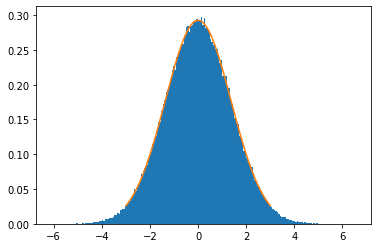

In [27]:
import random
index = random.sample(range(d),1)
xindex = np.arange(-3,3,0.001)
mean = np.mean(result[:,index])
sd = np.std(result[:,index],dtype=np.float64)
yindex = scipy.stats.norm.pdf(xindex,loc=mean,scale=sd)
plt.hist(result[:,index],bins=200,density=True)
plt.plot(xindex,yindex)
plt.show()

In [45]:
np.save('/data/shared/oz3/1000d_FinalResult_MirrorU.npy',result)